In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [7]:
df = pd.read_csv("./experiment/experiment_log.csv")

## CV-LBの相関

((0.0, 1.0), (0.0, 1.0))

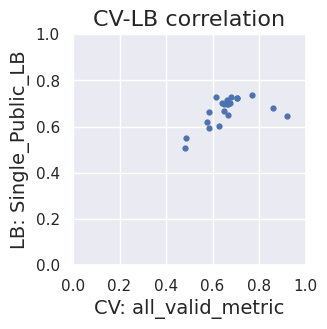

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), facecolor="white")

ax.scatter(df["all_valid_metric"], df["Single_Public_LB"], s=12)
ax.set_title("CV-LB correlation", fontsize=16)
ax.set_xlabel("CV: all_valid_metric", fontsize=14)
ax.set_ylabel("LB: Single_Public_LB", fontsize=14)
ax.set_xlim([0, 1]), ax.set_ylim([0, 1])

### バッチサイズとCV, LB

Text(500, 0.42, 'mean_valid_metric')

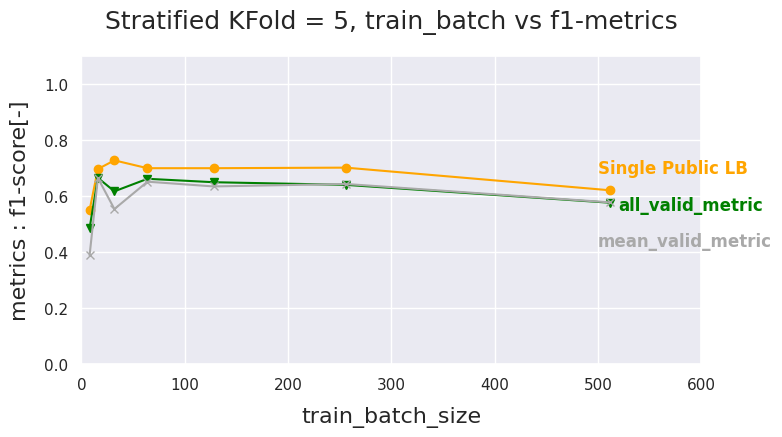

In [11]:
tdf = df[
    (df["run_id"].map(lambda x: "batch" in x)) |
    (df["run_id"] == "roberta_large")
    ].copy()
tdf["train_batch_size"] = [32, 16, 64, 128, 256, 512, 8]
tdf = tdf.sort_values("train_batch_size", ascending=True)

fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(8, 4))

ax.set_xlim([0, 600])
ax.set_ylim([0, 1.1])
ax.plot(tdf["train_batch_size"], tdf["Single_Public_LB"], c="orange", marker="o")
ax.plot(tdf["train_batch_size"], tdf["all_valid_metric"], c="green", marker="v")
ax.plot(tdf["train_batch_size"], tdf["mean_valid_metric"], c="darkgray", marker="x")

ax.set_title("Stratified KFold = 5, train_batch vs f1-metrics", fontsize=18, pad=20)
ax.set_xlabel("train_batch_size", fontsize=16, labelpad=10)
ax.set_ylabel("metrics : f1-score[-]", fontsize=16, labelpad=10)

ax.text(500, 0.68, "Single Public LB", c="orange", fontsize=12, fontweight="semibold")
ax.text(520, 0.55, "all_valid_metric", c="green", fontsize=12, fontweight="semibold")
ax.text(500, 0.42, "mean_valid_metric", c="darkgray", fontsize=12, fontweight="semibold")